In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
plt.ion()

import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors
from sklearn.preprocessing import normalize
import csv
import numpy as np


In [ ]:
def load_subSets(ratio_train, ratio_valid, trainCsv, testCsv):
    dataTrain = np.genfromtxt(trainCsv , delimiter = ',') #lecture du fichier trainCsv
    dataTrain = dataTrain[1:] #donnees generales du fichier trainCsv
    y = dataTrain[:,0] #labels
    X = dataTrain[:,1:] #donnees sans leur label
    
    Ntot   = X.shape[0] #nombre d'images dans les donnees X
    Ntrain = int(ratio_train*Ntot) 
    Nvalid = int(ratio_valid*Ntot)
    
    X_train = X[0: Ntrain].copy() #les donnees qu'on utilise pour entrainer les modeles
    y_train = y[0: Ntrain].copy() #les labels associes 
    
    X_valid = X[Ntrain:Ntrain+Nvalid].copy() #les donnees qu'on utilise pour tester les modeles
    y_valid = y[Ntrain:Ntrain+Nvalid].copy() #les labels associes
        
    dataTest = np.genfromtxt(testCsv, delimiter = ',') #lecture du fichier testCsv
    dataTest = dataTest[1:] #donnees generales du fichier testCsv, celles que le modele ne connait pas
    X_test  = dataTest[:,1:] #labels
    y_test  = dataTest[:,0] #donnees sans leur label
    
    return X, y, X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
dimRepre = 28
ratio_train = 0.7
ratio_valid = 0.3

X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(ratio_train, ratio_valid, 'sign_mnist_train.csv','sign_mnist_test.csv')

In [2]:
# on charge nos données d'entraînements et de validations
# data = np.genfromtxt('sign_mnist_train.csv', delimiter = ',')
# data = data[1:]
# dimRepre = 28
# ratio_train = 0.7
# ratio_valid = 0.3
# data

array([[  3., 107., 118., ..., 204., 203., 202.],
       [  6., 155., 157., ..., 103., 135., 149.],
       [  2., 187., 188., ..., 195., 194., 195.],
       ...,
       [ 18., 174., 174., ..., 202., 200., 200.],
       [ 17., 177., 181., ...,  64.,  87.,  93.],
       [ 23., 179., 180., ..., 205., 209., 215.]])

In [3]:
#data.shape

(27455, 785)

In [4]:
#on extrait un tableau de label
#y = data[:,0]
#y.shape

(27455,)

In [5]:
#on extrait l'ensemble de données correspondants
# X = data[:,1:]
# X.shape

(27455, 784)

In [6]:
#on charge nos données de test
# dataTest = np.genfromtxt('sign_mnist_test.csv', delimiter = ',')
# dataTest = dataTest[1:]
# dataTest

array([[  6., 149., 149., ..., 112., 120., 107.],
       [  5., 126., 128., ..., 184., 182., 180.],
       [ 10.,  85.,  88., ..., 225., 224., 222.],
       ...,
       [  2., 190., 191., ..., 211., 209., 208.],
       [  4., 201., 205., ...,  67.,  70.,  63.],
       [  2., 173., 174., ..., 195., 193., 192.]])

In [7]:
# yTest = dataTest[:,0]
# yTest.shape

(7172,)

In [8]:
# XTest = dataTest[:,1:]
# XTest.shape

(7172, 784)

Text(0.5, 1.0, "Ceci est censé ressembler à la 16ème lettre de l'alphabet ;-)")

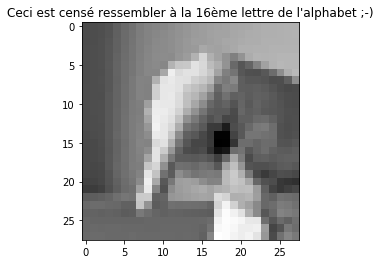

In [9]:
plt.figure()
idx = 15
labelIdx = y[idx] 
plt.imshow(X[idx].reshape(dimRepre, dimRepre), cm.gray)
plt.title("Ceci est censé ressembler à la "+str(int(y[idx]))+ "ème lettre de l'alphabet ;-)")

In [10]:
mask = (labelIdx == y)
X_bis = X[mask]
X_bis

array([[161., 168., 172., ..., 238., 255., 255.],
       [ 87.,  91.,  99., ...,   1.,   2.,   3.],
       [ 86.,  87.,  89., ..., 122., 141., 128.],
       ...,
       [ 59.,  62.,  69., ...,   0.,   0.,   0.],
       [ 81.,  83.,  86., ..., 222., 224., 225.],
       [153., 158., 161., ..., 211., 238., 231.]])

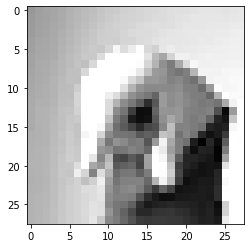

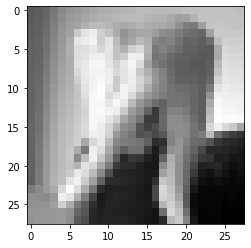

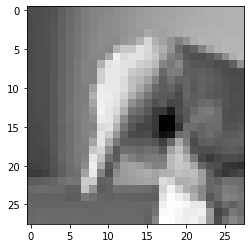

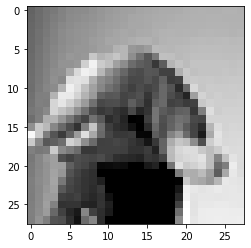

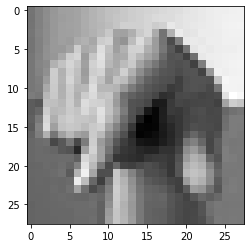

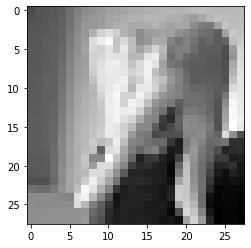

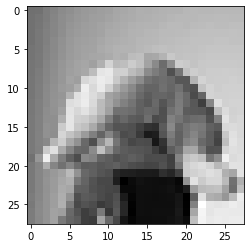

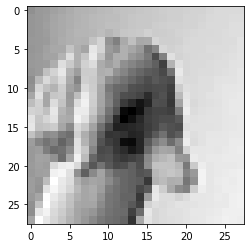

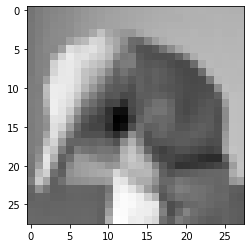

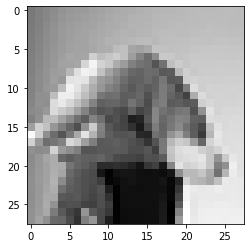

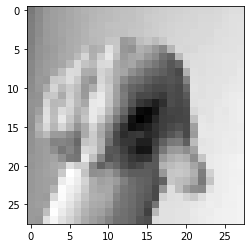

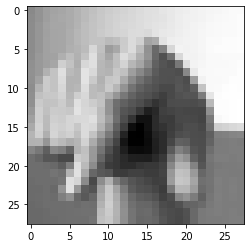

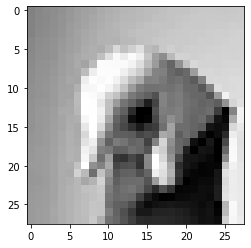

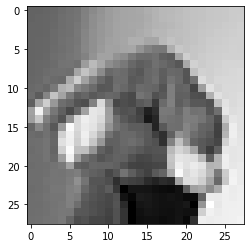

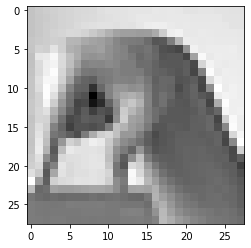

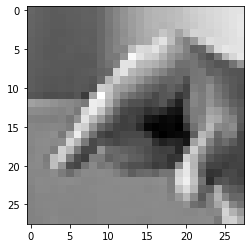

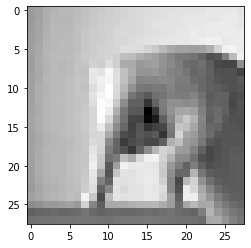

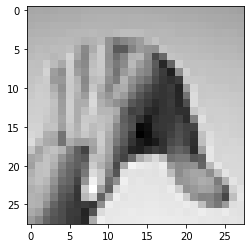

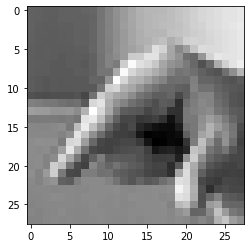

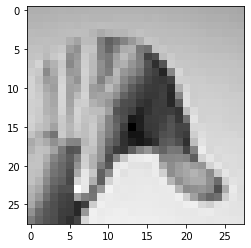

In [11]:
for i in X_bis[:20]:
    plt.figure()
    plt.imshow(i.reshape(dimRepre, dimRepre), cm.gray)

### Choix nombre de composants avec comparaison

In [ ]:
#nComp_range = np.array((np.arange(1,50,5)))

In [ ]:
training_score = []
valid_score = []

#nComp_range = n_components du PCA 
nComp_range = np.arange(1,50,5)

for nC in nComp_range:
    
    #compression des images en n_components pixels
    preProc = sklearn.decomposition.PCA(n_components = nC)
    #entrainement
    preProc.fit(X)
    #X_train_transformed = les donnees de X_train entraines, idem pour X_valid_transformed
    X_train_transformed = preProc.transform(X_train)
    X_valid_transformed = preProc.transform(X_valid)
    
    #ici clf = modele SVC
    clf = sklearn.svm.SVC(kernel = "poly", coef0 = 1, degree = 2)
    #entrainement avec X_train_transformed
    clf.fit(X_train_transformed, y_train)
    
    trainscore = clf.score(X_train_transformed, y_train)
    validscore = clf.score(X_valid_transformed, y_valid)
    
    print("nombre Composants", nC , "   training score:",trainscore, ". valid score:", validscore)
    
    training_score.append(trainscore)
    valid_score.append(validscore)

In [ ]:
plt.figure()
plt.plot(nComp_range, training_score, label= "train score")
plt.plot(nComp_range, valid_score   , label= "valid score")
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.5,1])
bestIndex = np.argmax(valid_score)
bestNC = nComp_range[bestIndex]
plt.plot(bestNC, valid_score[bestIndex], marker='X', color='green')

In [ ]:
nbCompOptimal = 16
#car bon score + plafone un peu après + nombre de composants le plus limités possible

In [ ]:
#on prépare nos données en les optimisants avec les meilleurs

preProc = sklearn.decomposition.PCA(n_components = nbCompOptimal)
preProc.fit(X)

X_train_transformed = preProc.transform(X_train)
X_valid_transformed = preProc.transform(X_valid)

X_train_decompressees = preProc.inverse_transform(X_train_transformed)

In [ ]:
plt.figure()
plt.imshow(X_train_decompressees[15].reshape(dimRepre, dimRepre), cm.gray)

### comparaison pour une autre svm

In [ ]:
clfLinearSVC = sklearn.svm.LinearSVC()
clfLinearSVC.fit(normalize(X_train_transformed), y_train)

trainscore = clfLinearSVC.score(X_train_transformed, y_train)
validscore = clfLinearSVC.score(X_valid_transformed, y_valid)
print("nombre Composants", 50 , "   training score:",trainscore, ". valid score:", validscore)

In [ ]:
clfNuSVC = sklearn.svm.NuSVC()
clfNuSVC.fit(X_train_transformed, y_train)

trainscore = clfNuSVC.score(X_train_transformed, y_train)
validscore = clfNuSVC.score(X_valid_transformed, y_valid)
print("nombre Composants", 50 , "   training score:",trainscore, ". valid score:", validscore)

### cross-validation

In [ ]:
num_folds = 10
kfold = sklearn.model_selection.KFold(n_splits=num_folds)
kfold

In [ ]:
monScoring = sklearn.model_selection.cross_val_score(estimator = clf, X = X, y = y, cv= kfold, scoring= 'neg_mean_squared_error')